# 0. Description

This notebook shows how the results of ML experiments were generated during the experimentation phase of the thesis. Every model (Linear Regressor, SVM and Random Forest) had assigned a similar notebook, where the only significant differences were the classfier used and the hyperparameters explored. The code is divided in the following structure.

1. The images are transformed to HOG descriptors.
2. Experimentation.
    - The classifier is trained and evalued with its default hyperaparmeters for an unbalanced dataset.
    - The classifier is trained and evalued with its default hyperparameters for a balanced dataset (via oversampling of the miniroity class in the training set of every cross validation partition).
    - GridSearch to tune the hyperaprameters' values with a balanced/oversampled dataset.

# 1. HOG Transformation

## Starting Point

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from torchvision.transforms import v2
import numpy as np
from tqdm.auto import tqdm
import utilities.dataset
from utilities.common import reproducibility
from torchvision import transforms
import torch
from skimage.feature import hog
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, make_scorer
from utilities.common import sensitivity_score
from utilities.common import specifity_score
import torch
from pprint import pprint
from matplotlib import pyplot as plt

,ID,DATE BIRTH,DATE RX,SEX,età,# Mouth Images,# Wrist Images,Mouth Images Names,Wrist Images Names,¿Adulto?
0,2,1991-12-23,2003-04-08,M,11.298630,1,1,../../Data South Africa/Black xrays\2.JPG,../../Data South Africa/black South African ha...,0
1,3,1991-11-22,2000-11-16,F,8.991781,1,1,../../Data South Africa/Black xrays\3.JPG,../../Data South Africa/black South African ha...,0
2,4,1989-04-04,2002-12-10,F,13.693151,1,1,../../Data South Africa/Black xrays\4 .JPG,../../Data South Africa/black South African ha...,0
3,6,2002-12-14,2014-06-18,M,11.517808,1,1,../../Data South Africa/Black xrays\6 .JPG,../../Data South Africa/black South African ha...,0
4,7,2002-05-14,2011-02-18,M,8.772603,1,0,../../Data South Africa/Black xrays\7.JPG,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1389,2265,1994-05-25,2009-01-08,M,14.635616,1,0,../../Data South Africa/Black xrays\2265 tsela...,NaN,0
1390,2267,2006-09-18,2014-07-02,M,7.791781,1,0,../../Data South Africa/Black xrays\2267.jpg,NaN,0
1391,2268,2005-10-02,2012-10-02,M,7.005479,1,0,../../Data South Africa/Black xrays\2268.jpg,NaN,0
1392,2269,2002-08-03,2013-06-28,F,10.909589,1,0,../../Data South Africa/Black xrays\2269.jpg,NaN,0


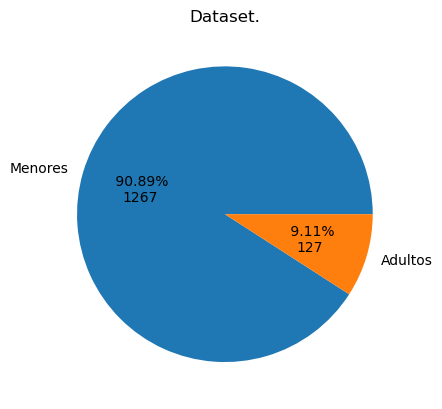

In [2]:
# Dataset
data_path = f'../data/trainval_df.csv'
dataset_df = pd.read_csv(data_path)
# Frame
display.display(dataset_df)
# Plot
num_menores = len(dataset_df.loc[dataset_df['¿Adulto?']==0])
num_adultos = len(dataset_df.loc[dataset_df['¿Adulto?']==1])
fig, axs = plt.subplots(1, 1)
fig.set_facecolor("w")
fig.set_figheight(fig.get_figheight()*1)
fig.set_figwidth(fig.get_figwidth()*1)
axs.pie(
    [num_menores, num_adultos], 
    labels=['Menores', 'Adultos'], 
    autopct=lambda p: f' {p:.2f}%\n{p*(num_menores+num_adultos)/100:.0f}',
    )
axs.set_title("Dataset.")
plt.show()

## HOG

In [3]:
# ------ Hyperparameters ------
height = 128
width = 64
resizing_scale = 1
cell_scale = 1
pixels_per_cell = [8*cell_scale, 8*cell_scale]
norm_scale = 1
cells_per_block = [2*norm_scale, 2*norm_scale]
orientations = 9
block_norm = 'L2'

In [4]:
# ------ Loading resized images in Memory ------
transformations = transforms.Compose(
        [
        # PIL.Image (int8 in [0, 255]) --> Pytorch.Tensor (float32 in [0.0, 1.0]).
        transforms.ToTensor(),
        # Changes the dimensions of the image.
        transforms.Resize(
            size = [height*resizing_scale,width*resizing_scale],
            interpolation = transforms.InterpolationMode.BILINEAR,
            max_size = None,
            antialias=False #'warn'
            ),
    ]
)
ram_dataset = utilities.dataset.RAMDataset(
    metadata_df             = dataset_df, 
    path_col                = 'Mouth Images Names', 
    label_col               = '¿Adulto?',
    transforms              = transformations,
    verbose                 = True,
)

Loading/Transforming Images:   0%|          | 0/1394 [00:00<?, ?it/s]

In [5]:
# ------ Application ------
Y_train = []
Y_train = ram_dataset.labels.tolist()
X_train = []
for t in tqdm(ram_dataset.imgs, unit="image", desc ='HOG transformation Progress: '):
    mean, std = torch.std_mean(t, dim=[1,2])
    t_norm = v2.functional.normalize(t, mean, std)
    hog_fd, hog_image = hog(
        t.permute([1,2,0]).numpy(), 
        orientations=orientations, 
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block, 
        visualize=True,
        feature_vector=True, 
        channel_axis=-1
    )
    X_train.append(hog_fd)

HOG transformation Progress:   0%|          | 0/1394 [00:00<?, ?image/s]

In [6]:
X_train = torch.tensor(np.array(X_train))
Y_train = torch.tensor(np.array(Y_train))

In [7]:
print(f"--> X_trian: \n\t--> Nº intances = {len(X_train)}\n\t--> Nº Features = {X_train[0].shape[0]}")
print(f"--> Y_train: \n\t--> Nº labels = {len(Y_train)}")

--> X_trian: 
	--> Nº intances = 1394
	--> Nº Features = 3780
--> Y_train: 
	--> Nº labels = 1394


# 2. Experimentation

## Results Folder

In [ ]:
from utilities.common import safeMkdir
exp_path = "../results/ML_experiment_example"
safeMkdir(exp_path)

## 2.1 Unbalanced

In [10]:
# -------- Cross-Validaiton Indexes --------
n_splits = 5
skf_seed = 1234
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=skf_seed)
train_idxs = [train_idxs for train_idxs, _ in kf.split(X=torch.zeros(len(Y_train)), y=Y_train)]
val_idxs = [val_idxs for _, val_idxs in kf.split(X=torch.zeros(len(Y_train)), y=Y_train)]
cv = []
for t, v in zip(train_idxs, val_idxs):
  cv.append([t,v])

# -------- Hyperparameters --------
random_state=1234
metrics_func = {
    #'loss':log_loss,
    'acc':accuracy_score,
    'sen':sensitivity_score,
    'spe':specifity_score
}
C=1.0
kernel ='rbf'
gamma ='scale'
degree = 3


clf = SVC(
  random_state = random_state,
  kernel    = kernel,
  gamma  = gamma,
  degree    = degree,
)

# -------- CV --------
cv_scores = cross_validate(
                estimator = clf,
                X         = X_train,
                y         = Y_train,
                scoring    = {
                    'acc':make_scorer(accuracy_score),
                    'sen':make_scorer(sensitivity_score),
                    'spe':make_scorer(specifity_score),
                },
                cv        = cv,
                return_train_score = True,
                verbose = 4
)
# -------- Store results --------
display.display(pd.DataFrame(cv_scores))
pd.DataFrame(cv_scores).to_csv(f"{exp_path}/unbalanced.csv")

[CV] END  acc: (train=0.919, test=0.910) sen: (train=0.118, test=0.000) spe: (train=1.000, test=1.000) total time=   1.6s
[CV] END  acc: (train=0.926, test=0.903) sen: (train=0.196, test=0.040) spe: (train=1.000, test=0.988) total time=   1.6s
[CV] END  acc: (train=0.916, test=0.907) sen: (train=0.069, test=0.000) spe: (train=1.000, test=1.000) total time=   1.6s
[CV] END  acc: (train=0.909, test=0.907) sen: (train=0.000, test=0.000) spe: (train=1.000, test=1.000) total time=   1.6s
[CV] END  acc: (train=0.923, test=0.910) sen: (train=0.157, test=0.000) spe: (train=1.000, test=1.000) total time=   1.5s


,fit_time,score_time,test_acc,train_acc,test_sen,train_sen,test_spe,train_spe
0,1.280735,0.438036,0.910394,0.919283,0.00,0.117647,1.000000,1.0
1,1.277632,0.430971,0.903226,0.926457,0.04,0.196078,0.988189,1.0
2,1.234569,0.435546,0.906810,0.915695,0.00,0.069307,1.000000,1.0
3,1.243377,0.456268,0.906810,0.909417,0.00,0.000000,1.000000,1.0
4,1.218441,0.424534,0.910072,0.922939,0.00,0.156863,1.000000,1.0


### Mean and STD

In [11]:
results = pd.read_csv(f"{exp_path}/unbalanced.csv")

metrics = {}
for m in ['acc', 'sen', 'spe']:
    metrics[f'test_{m}'] = []
metrics[f'M_cv'] = []
metrics[f'O_sen'] = []

for m in ['acc', 'sen', 'spe']:
    metrics[f'test_{m}'].append(results.mean()[f'test_{m}'])
metrics['M_cv'].append(abs(metrics['test_sen'][-1] - metrics['test_spe'][-1]))
metrics['O_sen'].append(abs(results.mean()['train_sen'] - results.mean()['test_sen']))

print(metrics)
print(pd.DataFrame(metrics).to_latex(float_format="%.4f", index=False, header=["acc", "sen", "spe", "mcv", "osen"]))

{'test_acc': [0.9074624171630438], 'test_sen': [0.008], 'test_spe': [0.9976377952755906], 'M_cv': [0.9896377952755906], 'O_sen': [0.09997903319743737]}
\begin{tabular}{rrrrr}
\toprule
acc & sen & spe & mcv & osen \\
\midrule
0.9075 & 0.0080 & 0.9976 & 0.9896 & 0.1000 \\
\bottomrule
\end{tabular}



## 2.2 Balanced

In [12]:
# -------- Cross-Validaiton Indexes --------
n_splits = 5
skf_seed = 1234
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=skf_seed)
train_idxs = [train_idxs for train_idxs, _ in kf.split(X=torch.zeros(len(Y_train)), y=Y_train)]
val_idxs = [val_idxs for _, val_idxs in kf.split(X=torch.zeros(len(Y_train)), y=Y_train)]

# -------- Oversampling --------
for k, train_idxs_for_k in enumerate(train_idxs):
    train_pos = dataset_df.iloc[train_idxs_for_k].loc[dataset_df['¿Adulto?']==1]
    train_neg = dataset_df.iloc[train_idxs_for_k].loc[dataset_df['¿Adulto?']==0]
    # Oversampling algorithm
    new_train_idxs = np.hstack((
        train_neg.index.to_numpy(), 
        *[train_pos.index.to_numpy() for i in range(len(train_neg)//len(train_pos))],
        train_pos.sample(n=len(train_neg)-int(len(train_neg)//len(train_pos))*len(train_pos), random_state=skf_seed).index.to_numpy()
    ))
    train_idxs[k] = new_train_idxs

cv = []
for t, v in zip(train_idxs, val_idxs):
  cv.append([t,v])

# -------- Hyperparameters --------
random_state=1234
metrics_func = {
    #'loss':log_loss,
    'acc':accuracy_score,
    'sen':sensitivity_score,
    'spe':specifity_score
}
C=1.0
kernel ='rbf'
gamma ='scale'
degree = 3


clf = SVC(
  random_state = random_state,
  kernel    = kernel,
  gamma  = gamma,
  degree    = degree,
)


# -------- CV --------
cv_scores = cross_validate(
                estimator = clf,
                X         = X_train,
                y         = Y_train,
                scoring    = {
                    #'loss':make_scorer(log_loss),
                    'acc':make_scorer(accuracy_score),
                    'sen':make_scorer(sensitivity_score),
                    'spe':make_scorer(specifity_score),
                },
                cv        = cv,
                return_train_score = True,
                verbose = 4
)
# -------- Store results --------
display.display(pd.DataFrame(cv_scores))
pd.DataFrame(cv_scores).to_csv(f"{exp_path}/balanced.csv")

[CV] END  acc: (train=0.994, test=0.914) sen: (train=1.000, test=0.200) spe: (train=0.988, test=0.984) total time=   4.1s
[CV] END  acc: (train=0.996, test=0.889) sen: (train=1.000, test=0.320) spe: (train=0.991, test=0.945) total time=   4.2s
[CV] END  acc: (train=0.994, test=0.900) sen: (train=1.000, test=0.269) spe: (train=0.987, test=0.964) total time=   4.0s
[CV] END  acc: (train=0.996, test=0.918) sen: (train=1.000, test=0.346) spe: (train=0.991, test=0.976) total time=   4.0s
[CV] END  acc: (train=0.994, test=0.896) sen: (train=1.000, test=0.200) spe: (train=0.988, test=0.964) total time=   4.0s


,fit_time,score_time,test_acc,train_acc,test_sen,train_sen,test_spe,train_spe
0,3.511107,0.682111,0.913978,0.994077,0.200000,1.0,0.984252,0.988154
1,3.612666,0.693691,0.888889,0.995558,0.320000,1.0,0.944882,0.991115
2,3.399056,0.679862,0.899642,0.993590,0.269231,1.0,0.964427,0.987179
3,3.387192,0.667385,0.917563,0.995562,0.346154,1.0,0.976285,0.991124
4,3.391745,0.674366,0.895683,0.994083,0.200000,1.0,0.964427,0.988166


### Mean and STD

In [13]:
results = pd.read_csv(f"{exp_path}/balanced.csv")

metrics = {}
for m in ['acc', 'sen', 'spe']:
    metrics[f'test_{m}'] = []
metrics[f'M_cv'] = []
metrics[f'O_sen'] = []

for m in ['acc', 'sen', 'spe']:
    metrics[f'test_{m}'].append(results.mean()[f'test_{m}'])
metrics['M_cv'].append(abs(metrics['test_sen'][-1] - metrics['test_spe'][-1]))
metrics['O_sen'].append(abs(results.mean()['train_sen'] - results.mean()['test_sen']))

print(metrics)
print(pd.DataFrame(metrics).to_latex(float_format="%.4f", index=False, header=["acc", "sen", "spe", "mcv", "osen"]))

{'test_acc': [0.9031510275650447], 'test_sen': [0.26707692307692305], 'test_spe': [0.966854439637733], 'M_cv': [0.69977751656081], 'O_sen': [0.732923076923077]}
\begin{tabular}{rrrrr}
\toprule
acc & sen & spe & mcv & osen \\
\midrule
0.9032 & 0.2671 & 0.9669 & 0.6998 & 0.7329 \\
\bottomrule
\end{tabular}



## 2.3 GridSearchCV

In [47]:
# -------- Cross-Validaiton Indexes --------
n_splits = 5
skf_seed = 1234
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=skf_seed)
train_idxs = [train_idxs for train_idxs, _ in kf.split(X=torch.zeros(len(Y_train)), y=Y_train)]
val_idxs = [val_idxs for _, val_idxs in kf.split(X=torch.zeros(len(Y_train)), y=Y_train)]

# -------- Oversampling --------
for k, train_idxs_for_k in enumerate(train_idxs):
    train_pos = dataset_df.iloc[train_idxs_for_k].loc[dataset_df['¿Adulto?']==1]
    train_neg = dataset_df.iloc[train_idxs_for_k].loc[dataset_df['¿Adulto?']==0]
    # Oversampling algorithm
    new_train_idxs = np.hstack((
        train_neg.index.to_numpy(), 
        *[train_pos.index.to_numpy() for i in range(len(train_neg)//len(train_pos))],
        train_pos.sample(n=len(train_neg)-int(len(train_neg)//len(train_pos))*len(train_pos), random_state=skf_seed).index.to_numpy()
    ))
    train_idxs[k] = new_train_idxs

cv = []
for t, v in zip(train_idxs, val_idxs):
  cv.append([t,v])

# -------- Hyperparameters --------
random_state=1234
metrics_func = {
    #'loss':log_loss,
    'acc':accuracy_score,
    'sen':sensitivity_score,
    'spe':specifity_score
}
C=1.0
kernel ='rbf'
gamma ='scale'
degree = 3


clf = SVC(
  random_state = random_state,
  kernel    = kernel,
  gamma  = gamma,
  degree    = degree,
)

# -------- GridSearchCV --------
param_grid = [
                {
                    'kernel':['poly'],
                    'C':[0.001, 0.01, 0.1, 1.0, 10.0],
                    'degree':[2,5,10],
                    'gamma':['scale', 'auto']
                  },
                  {
                    'kernel':['rbf','sigmoid'],
                    'C':[0.001, 0.01, 0.1, 1.0, 10.0],
                    'gamma':['scale', 'auto']
                  },
                  {
                    'kernel':['linear'],
                    'C':[0.001, 0.01, 0.1, 1.0, 10.0],
                  },
            ]

grid = GridSearchCV(
        estimator  = clf,
        param_grid = param_grid,
        scoring    = {
            #'loss':make_scorer(log_loss),
            'acc':make_scorer(accuracy_score),
            'sen':make_scorer(sensitivity_score),
            'spe':make_scorer(specifity_score),
        },
        cv         = cv,
        return_train_score = True,
        refit = False,
        verbose    = 4
)
_ = grid.fit(X = X_train, y = Y_train)
pd.DataFrame(grid.cv_results_).to_csv(f"{exp_path}/grid_search.csv", index = False)

Fitting 5 folds for each of 55 candidates, totalling 275 fits
[CV 1/5] END C=0.001, degree=2, gamma=scale, kernel=poly; acc: (train=0.619, test=0.885) sen: (train=0.294, test=0.280) spe: (train=0.944, test=0.945) total time=   8.1s
[CV 2/5] END C=0.001, degree=2, gamma=scale, kernel=poly; acc: (train=0.612, test=0.878) sen: (train=0.274, test=0.360) spe: (train=0.949, test=0.929) total time=   8.1s
[CV 3/5] END C=0.001, degree=2, gamma=scale, kernel=poly; acc: (train=0.619, test=0.900) sen: (train=0.298, test=0.269) spe: (train=0.941, test=0.964) total time=   8.1s
[CV 4/5] END C=0.001, degree=2, gamma=scale, kernel=poly; acc: (train=0.613, test=0.896) sen: (train=0.278, test=0.346) spe: (train=0.948, test=0.953) total time=   8.0s
[CV 5/5] END C=0.001, degree=2, gamma=scale, kernel=poly; acc: (train=0.631, test=0.874) sen: (train=0.314, test=0.200) spe: (train=0.949, test=0.941) total time=   7.6s
[CV 1/5] END C=0.001, degree=2, gamma=auto, kernel=poly; acc: (train=0.619, test=0.885) 

In [12]:
cv_results = pd.read_csv(f"{exp_path}/grid_search.csv")
cv_results['M_cv'] = cv_results.apply(lambda row: abs(row['mean_test_sen'] - row['mean_test_spe']), axis=1)
cv_results['sen_spe_mean'] = cv_results.apply(lambda row: (row['mean_test_sen'] + row['mean_test_spe'])*0.5, axis=1)
cv_results['O_sen'] = cv_results.apply(lambda row: row['mean_train_sen'] - row['mean_test_sen'], axis=1)
cols = []
#cols.append("params")
for hyper in eval(cv_results['params'].iloc[0]).keys():
    cv_results[hyper] = cv_results.apply(lambda row: eval(row['params'])[hyper] if hyper in eval(row['params']).keys() else '-', axis=1)
    cols.append(hyper)
for m in ["acc", "sen", "spe"]:
    cols.append(f"mean_test_{m}")
cols.append("M_cv")
cols.append("O_sen")
cols.append("sen_spe_mean")
print("Vanilla")
display.display(cv_results[cols])
print("Best 20 (based on M_cv)")
display.display(cv_results[cols].sort_values('M_cv', ascending=True)[:20])
print("Best (based on mean(sen, spe))")
display.display(cv_results[cols].sort_values('sen_spe_mean', ascending=False)[:20])

Vanilla


,C,degree,gamma,kernel,mean_test_acc,mean_test_sen,mean_test_spe,M_cv,O_sen,sen_spe_mean
0,0.001,2,scale,poly,0.886648,0.291077,0.946345,0.655268,0.000554,0.618711
1,0.001,2,auto,poly,0.886648,0.291077,0.946345,0.655268,0.000554,0.618711
2,0.001,5,scale,poly,0.797708,0.424308,0.835044,0.410736,0.336143,0.629676
3,0.001,5,auto,poly,0.835721,0.362154,0.883212,0.521059,0.086750,0.622683
4,0.001,10,scale,poly,0.907457,0.109846,0.987380,0.877534,0.890154,0.548613
5,0.001,10,auto,poly,0.897411,0.291077,0.958181,0.667104,0.240897,0.624629
6,0.010,2,scale,poly,0.876612,0.338154,0.930553,0.592399,0.061614,0.634353
7,0.010,2,auto,poly,0.886648,0.291077,0.946345,0.655268,0.000554,0.618711
8,0.010,5,scale,poly,0.897414,0.283077,0.958962,0.675885,0.716923,0.621019
9,0.010,5,auto,poly,0.835721,0.362154,0.883212,0.521059,0.086750,0.622683


Best 20 (based on M_cv)


,C,degree,gamma,kernel,mean_test_acc,mean_test_sen,mean_test_spe,M_cv,O_sen,sen_spe_mean
29,10.000,10,auto,poly,0.638426,0.620615,0.640080,0.019464,0.271642,0.630348
47,10.000,-,scale,sigmoid,0.663554,0.636923,0.666089,0.029166,0.086042,0.651506
23,1.000,10,auto,poly,0.677881,0.543077,0.691420,0.148343,0.299863,0.617248
48,10.000,-,auto,rbf,0.792679,0.471692,0.824752,0.353059,0.424325,0.648222
51,0.010,-,-,linear,0.814912,0.486769,0.847639,0.360870,0.495667,0.667204
43,1.000,-,scale,sigmoid,0.800593,0.463692,0.834235,0.370543,0.097875,0.648964
49,10.000,-,auto,sigmoid,0.799146,0.456000,0.833460,0.377460,0.302282,0.644730
2,0.001,5,scale,poly,0.797708,0.424308,0.835044,0.410736,0.336143,0.629676
12,0.100,2,scale,poly,0.837155,0.448308,0.876067,0.427759,0.543799,0.662187
38,0.100,-,scale,rbf,0.832861,0.385231,0.877663,0.492433,0.382919,0.631447


Best (based on mean(sen, spe))


,C,degree,gamma,kernel,mean_test_acc,mean_test_sen,mean_test_spe,M_cv,O_sen,sen_spe_mean
51,0.010,-,-,linear,0.814912,0.486769,0.847639,0.360870,0.495667,0.667204
12,0.100,2,scale,poly,0.837155,0.448308,0.876067,0.427759,0.543799,0.662187
47,10.000,-,scale,sigmoid,0.663554,0.636923,0.666089,0.029166,0.086042,0.651506
43,1.000,-,scale,sigmoid,0.800593,0.463692,0.834235,0.370543,0.097875,0.648964
48,10.000,-,auto,rbf,0.792679,0.471692,0.824752,0.353059,0.424325,0.648222
49,10.000,-,auto,sigmoid,0.799146,0.456000,0.833460,0.377460,0.302282,0.644730
50,0.001,-,-,linear,0.870880,0.346154,0.923445,0.577291,0.061511,0.634799
6,0.010,2,scale,poly,0.876612,0.338154,0.930553,0.592399,0.061614,0.634353
38,0.100,-,scale,rbf,0.832861,0.385231,0.877663,0.492433,0.382919,0.631447
29,10.000,10,auto,poly,0.638426,0.620615,0.640080,0.019464,0.271642,0.630348


Generating latex table.

In [13]:
print(cv_results[['kernel', 'degree', 'C', 'gamma', 'mean_test_acc','mean_test_sen', 'mean_test_spe', 'M_cv', 'O_sen']].sort_values('M_cv')[:20].to_latex(float_format="%.4f", index=False, header=['kernel', 'degree', 'C', 'gamma', 'mean_test_acc','mean_test_sen', 'mean_test_spe', 'M_cv', 'O_sen']))

\begin{tabular}{llrlrrrrr}
\toprule
kernel & degree & C & gamma & mean_test_acc & mean_test_sen & mean_test_spe & M_cv & O_sen \\
\midrule
poly & 10 & 10.0000 & auto & 0.6384 & 0.6206 & 0.6401 & 0.0195 & 0.2716 \\
sigmoid & - & 10.0000 & scale & 0.6636 & 0.6369 & 0.6661 & 0.0292 & 0.0860 \\
poly & 10 & 1.0000 & auto & 0.6779 & 0.5431 & 0.6914 & 0.1483 & 0.2999 \\
rbf & - & 10.0000 & auto & 0.7927 & 0.4717 & 0.8248 & 0.3531 & 0.4243 \\
linear & - & 0.0100 & - & 0.8149 & 0.4868 & 0.8476 & 0.3609 & 0.4957 \\
sigmoid & - & 1.0000 & scale & 0.8006 & 0.4637 & 0.8342 & 0.3705 & 0.0979 \\
sigmoid & - & 10.0000 & auto & 0.7991 & 0.4560 & 0.8335 & 0.3775 & 0.3023 \\
poly & 5 & 0.0010 & scale & 0.7977 & 0.4243 & 0.8350 & 0.4107 & 0.3361 \\
poly & 2 & 0.1000 & scale & 0.8372 & 0.4483 & 0.8761 & 0.4278 & 0.5438 \\
rbf & - & 0.1000 & scale & 0.8329 & 0.3852 & 0.8777 & 0.4924 & 0.3829 \\
poly & 5 & 10.0000 & auto & 0.8357 & 0.3622 & 0.8832 & 0.5211 & 0.0867 \\
poly & 5 & 0.1000 & auto & 0.8357 & 0.36